# Predicting apple phone prices based on other company phone data

## Imports

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Deepening our understanding about the data

In [28]:
# Load the data
df = pd.read_csv('origPhoneData.csv')

# Deleting index, Name, Brand, Model, Operating system, Wi-fi, Bluetooth, GPS, Number of SIMs, 3G, 
# 4G/LTE, and Touchscreen
df.drop(
    columns=['Unnamed: 0', 'Name', 'Brand', 'Model', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', 
             'Number of SIMs', '3G', '4G/ LTE', 'Touchscreen'], 
    axis=1, inplace=True
)

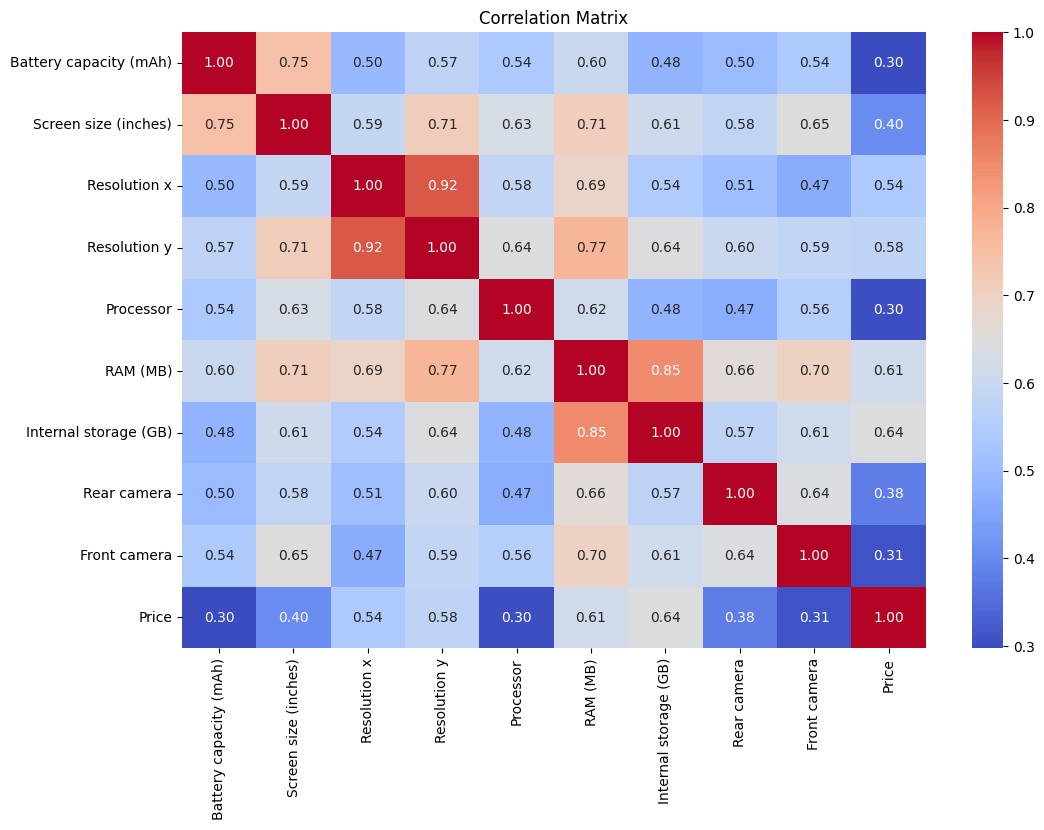

In [29]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


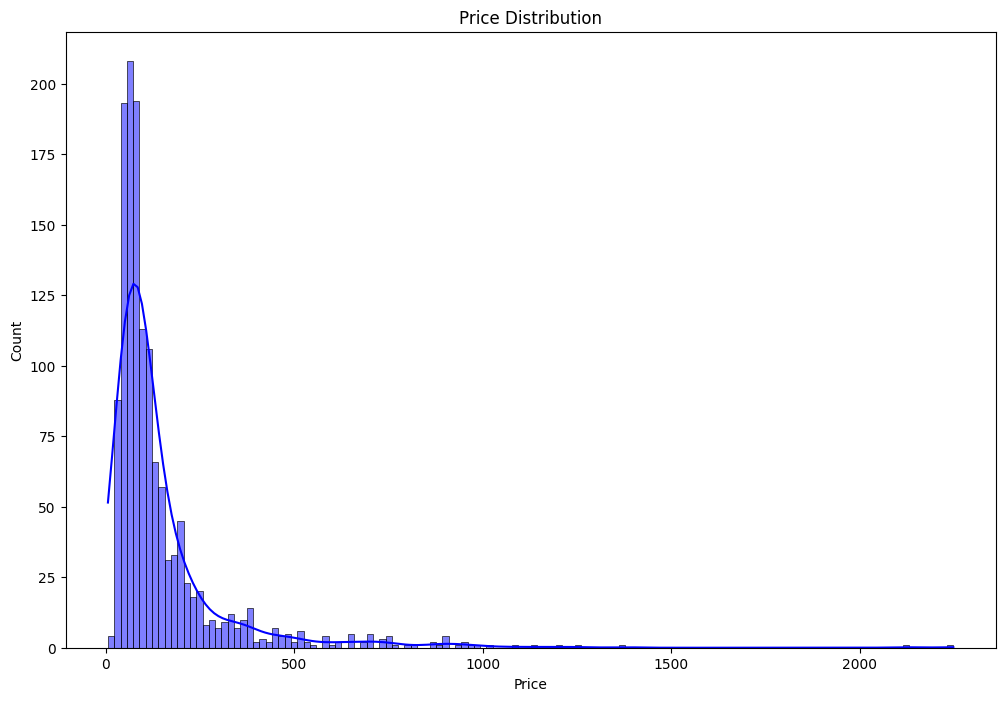

In [30]:
# Visualize price distribution
plt.figure(figsize=(12, 8))
# Convert indian rupees to euros and inflation adjust from 2022 to 2024
sns.histplot(df['Price'] * 0.012 * 1.0708, kde=True, color='blue')
plt.title('Price Distribution')
plt.show()

## Fitting models

### Processing data

In [31]:
# load the data again
df = pd.read_csv('origPhoneData.csv')

# Add all apple products to a file
apple_df = df[df['Brand'] == 'Apple']
apple_df.to_csv('data/appleProducts.csv', index=False)

# Delete apple products
df = df[df['Brand'] != 'Apple'] 

# Deleting index, Name, Brand, Model, Operating system, Wi-fi, Bluetooth, GPS, Number of SIMs, 3G, 
# 4G/LTE, and Touchscreen
df.drop(
    columns=['Unnamed: 0', 'Name', 'Brand', 'Model', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', 
             'Number of SIMs', '3G', '4G/ LTE', 'Touchscreen'], 
    axis=1, inplace=True
)

# Indian rupees to euros and inflation adjust from 2022 to 2024.
df.insert(len(df.columns), 'Price euro', df['Price'] * 0.012 * 1.0708)
df.drop('Price', axis=1, inplace=True)

# Calculate ratio of resolution x and y
df.insert(len(df.columns), 'Resolution ratio', df['Resolution y'] / df['Resolution x'])
df.drop(['Resolution x', 'Resolution y'], axis=1, inplace=True)

# save to modified data to file
df.to_csv('data/processedData.csv', index=False)

In [32]:
# Load the processed data
df = pd.read_csv('data/processedData.csv')

# Define a threshold to distinguish low and high-priced phones
price_threshold = df['Price euro'].quantile(0.95)

# Separate the dataframe into low-priced and high-priced phones
low_priced_phones = df[df['Price euro'] < price_threshold]
high_priced_phones = df[df['Price euro'] >= price_threshold]

# Upsample high-priced phones
high_priced_phones_upsampled = resample(
    high_priced_phones, 
    replace=True,    
    n_samples=int(4 * len(low_priced_phones)),
    random_state=42
)

# Downsample low-priced phones
low_priced_phones_downsampled = resample(
    low_priced_phones,
    replace=False,   
    n_samples=int(0.2 * len(low_priced_phones)),
    random_state=42 
)

# Combine the upsampled high-priced with downsampled low-priced
balanced_df = pd.concat([low_priced_phones_downsampled, high_priced_phones_upsampled])

# Shuffle the dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced data to a new CSV file
balanced_df.to_csv('data/BalancedData.csv', index=False)

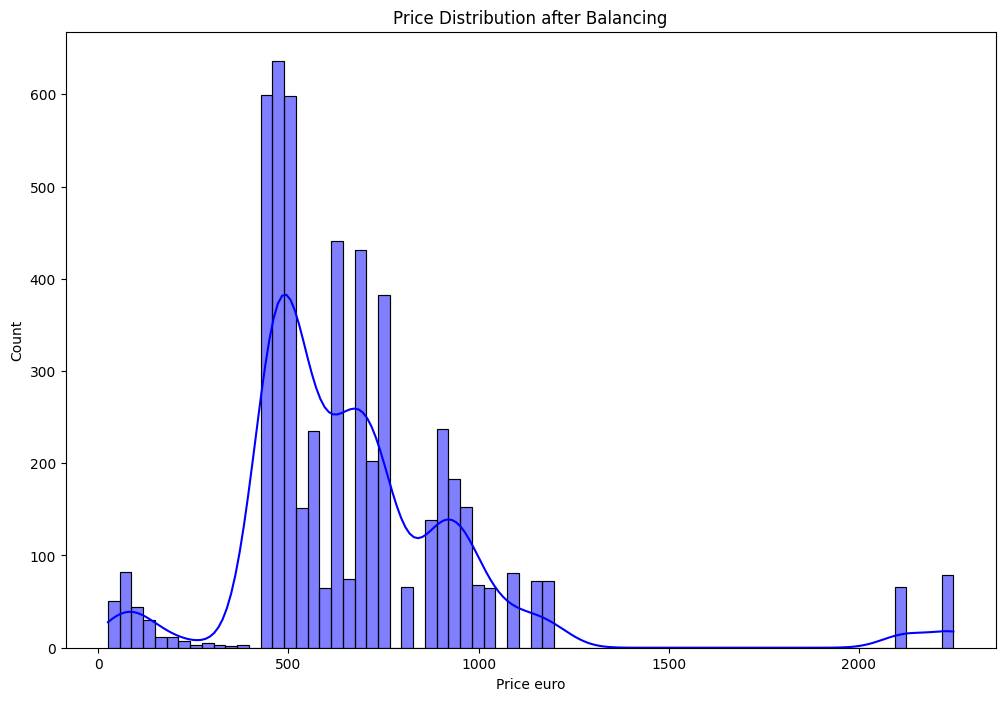

In [33]:
# Load the balanced data
df = pd.read_csv('data/balancedData.csv')

# Visualize price distribution
plt.figure(figsize=(12, 8))
sns.histplot(df['Price euro'], kde=True, color='blue')
plt.title('Price Distribution after Balancing')
plt.show()

### Train, validation, test split

In [46]:
# Load the processed dataset
data = pd.read_csv('data/BalancedData.csv')

# Separate the features and the target variable
X = data.drop('Price euro', axis=1)
y = data['Price euro']

# Split the data into training, validation, and testing sets (70-20-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# 0.333 x 0.3 = ~0.1
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42) 

### Utility functions

In [48]:

def validate_and_test(model, X_val, X_test, y_val, y_test):
    # Validate the model
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    print(f'Validation Mean Squared Error: {val_mse:.2f}')
    print(f'Validation R² Score: {val_r2:.2f}')
    print()

    # Test the model
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f'Test Mean Squared Error: {test_mse:.2f}')
    print(f'Test R² Score: {test_r2:.2f}')
    

### Linear regression

In [49]:
# Initialize and train a Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

validate_and_test(linear_regressor, X_val, X_test, y_val, y_test)

Validation Mean Squared Error: 74271.74
Validation R² Score: 0.36

Test Mean Squared Error: 73007.64
Test R² Score: 0.26


### Polynomial Regression

In [50]:
# Apply polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# Fit the regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

# Validate the model
y_val_pred = lin_reg.predict(X_val_poly)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f'Validation Mean Squared Error: {val_mse:.2f}')
print(f'Validation R² Score: {val_r2:.2f}')
print()

# Test the model
y_pred_poly = lin_reg.predict(X_test_poly)
test_mse = mean_squared_error(y_test, y_pred_poly)
test_r2 = r2_score(y_test, y_pred_poly)
print(f'Test Mean Squared Error: {test_mse:.2f}')
print(f'Test R² Score: {test_r2:.2f}')

Validation Mean Squared Error: 22130.35
Validation R² Score: 0.81

Test Mean Squared Error: 24284.08
Test R² Score: 0.75


### Multilayer perceptron

In [51]:
# Train the model
mlp = MLPRegressor(hidden_layer_sizes=(200, 200, 200, 200), max_iter=1000, random_state=42, activation='relu')
mlp.fit(X_train, y_train)

validate_and_test(mlp, X_val, X_test, y_val, y_test)

Validation Mean Squared Error: 5336.67
Validation R² Score: 0.95

Test Mean Squared Error: 5479.02
Test R² Score: 0.94


### Decision Tree

In [39]:
# Fit the model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Validate and test the model
validate_and_test(tree_reg, X_val, X_test, y_val, y_test)

Validation Mean Squared Error: 2818.00
Validation R² Score: 0.98

Test Mean Squared Error: 718.25
Test R² Score: 0.99


### Random Forest

In [40]:
# Train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

validate_and_test(rf_reg, X_val, X_test, y_val, y_test)

Validation Mean Squared Error: 3095.10
Validation R² Score: 0.97

Test Mean Squared Error: 779.83
Test R² Score: 0.99


## Conclusion

In [41]:
# load the data again
df = pd.read_csv('data/appleProducts.csv')

# Deleting index, Name, Brand, Model, Operating system, Wi-fi, Bluetooth, GPS, Number of SIMs, 3G, 
# 4G/LTE, and Touchscreen
df.drop(
    columns=['Unnamed: 0', 'Name', 'Brand', 'Model', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', 
             'Number of SIMs', '3G', '4G/ LTE', 'Touchscreen'], 
    axis=1, inplace=True
)

# Indian rupees to euros and inflation adjust from 2022 to 2024.
df.insert(len(df.columns), 'Price euro', df['Price'] * 0.012 * 1.0708)
df.drop('Price', axis=1, inplace=True)

# Calculate ratio of resolution x and y
df.insert(len(df.columns), 'Resolution ratio', df['Resolution y'] / df['Resolution x'])
df.drop(['Resolution x', 'Resolution y'], axis=1, inplace=True)

# save to modified data to file
df.to_csv('data/processedAppleProducts.csv', index=False)

In [42]:
# Create features and labels
X = df.drop(columns=["Price euro"])
y = df["Price euro"]

# Iterate over models and calculate average error.
models = [linear_regressor, mlp, tree_reg, rf_reg]
for model in models:
    y_pred = model.predict(X)
    comparison_df = pd.DataFrame({"Actual Price": y, "Predicted Price": y_pred})
    comparison_df['Price Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price']
    average_error = comparison_df['Price Difference'].sum() / len(comparison_df)
    print(f'{type(model).__name__}: {average_error:.2f}')

# Calculate average error.
y_pred = lin_reg.predict(poly.transform(X))
comparison_df = pd.DataFrame({"Actual Price": y, "Predicted Price": y_pred})
comparison_df['Price Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price']
average_error = comparison_df['Price Difference'].sum() / len(comparison_df)
print(f'PolynomialRegression (deg 2): {average_error:.2f}' )


    Actual Price  Predicted Price  Price Difference
0    1373.622240       624.355365        749.266875
1     808.239840       577.264048        230.975792
2     584.643950       553.277112         31.366838
3     899.459150       611.563892        287.895258
4     770.963150       561.352425        209.610725
5     475.422350       475.860032         -0.437682
6     603.931200       587.792630         16.138570
7     899.459150       526.749910        372.709241
8     449.723150       554.152746       -104.429595
9     359.775950       440.710016        -80.934065
10    333.961104       509.052952       -175.091848
11    218.430350       390.030199       -171.599848
12    295.527950       425.980592       -130.452641
13    308.377550       502.993430       -194.615880
14    205.580750       418.410938       -212.830187
15    109.208750       351.425650       -242.216900
16   1245.126240       554.231723        690.894517
LinearRegression: 75.07
    Actual Price  Predicted Price  Price